# imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable

import sys

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.tile_extraction.tiles import WsiInfo

from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.objects import ObjectManager
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai2
from fastai2.vision.all import *


from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil
from PIL import Image
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/')

WSIS_CORTICOTROP = PATH/'corticotrop'
WSIS_GONADOTROP = PATH/'gonadotrop'

ROIS_CORTICOTROP = PATH/'corticotrop_ROIs'
ROIS_GONADOTROP = PATH/'gonadotrop_ROIs'

TILES_CORTICOTROP_1 = PATH/'tiles_corticotrop_1_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_2 = PATH/'tiles_corticotrop_2_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_3 = PATH/'tiles_corticotrop_3_scoring_function_1_thresh_0.4'

TILES_GONADOTROP_1 = PATH/'tiles_gonadotrop_1_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_2 = PATH/'tiles_gonadotrop_2_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_3 = PATH/'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'

#TEST = PATH/TEST_NAME
#TEST = PATH_LOCAL/TEST_NAME
TEST_EXPERIMENTING = PATH/'tiles_test_100_for_testing'
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

torch.backends.cudnn.benchmark=True


seed = 19
np.random.seed(seed)

num2lbs = {
    0:"corticotrop", 
    3:"silent",  
    8:"LH", 
    9:"FSH"
}

lbs2num = {l:n for n,l in num2lbs.items()}

# data preprocessing 

## Extract tiles from rois on the fly 

### roi paths

In [4]:
roi_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                                                        get_files=True, 
                                                                        suffix='.png', 
                                                                        recursive=True, 
                                                                        folder_name=['gonadotrop_ROIs', 'corticotrop_ROIs'])

48it [00:13,  3.50it/s]


In [5]:
roi_paths = roi_paths[:5]

In [6]:
roi_paths.items[:5]

[Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_18-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_32-LH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png')]

In [7]:
len(roi_paths.items)

5

In [8]:
len(ROIS_CORTICOTROP.ls() + ROIS_GONADOTROP.ls())

13169

### id and label funcs

In [9]:
def get_case_id_from_path(path):
    """
    Arguments:
        path: roi path
    """
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def get_slide_name_from_path(path):
    """
    Arguments:
        path: roi path
    """
    path = Path(path)
    split = path.stem.split('-')
    try:
        return f'{split[0]}-{split[1]}-{split[2]}-{split[3]}'
    except IndexError:
        return f'{split[0]}-{split[1]}-{split[2]}'
    
df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path):
    """
    Arguments:
        path: roi path
    """
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return [lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['FSH']]
    elif 'ACTH' in s:
        result = [lbs2num['corticotrop']]
        id = get_case_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(lbs2num['silent']) in str(l.values[0]):
                result.append(3)
        except:
            print(l.values)
            print(s)
            print(get_slide_name_from_path(path))
            raise
        return result
    
def label_func_path_list(paths:List[pathlib.Path]):
    return [label_func(p) for p in paths]

### named objects

In [10]:
roi_case_id_getter=NameGetter(func_path_to_case_id=get_case_id_from_path).get_name_from_path
roi_slide_id_getter=NameGetter(func_path_to_case_id=get_slide_name_from_path).get_name_from_path

In [11]:
named_objects=NameGetter().create_named_object_from_path(path=roi_paths.items, 
                                                   case_id_getter=roi_case_id_getter, 
                                                   slide_id_getter=roi_slide_id_getter,
                                                   classification_labels_getter=label_func_path_list)

5it [00:00, 27060.03it/s]

Patient ID has not been specified!


### tile extraction

In [12]:
path_to_wsi_info = {}
for p in roi_paths.items:
    wsi_info = WsiInfo(path=p, 
                       patient_id=get_case_id_from_path, #one case per patient
                       case_id=get_case_id_from_path(p), 
                       slide_id=get_slide_name_from_path(p), 
                       classification_labels=label_func(p), 
                       dataset_type=None, 
                       rois=None)
    path_to_wsi_info[p] = wsi_info

In [ ]:
tile_size = 1024

In [22]:
tilesummaries = tiles.WsiOrROIToTilesMultithreaded(wsi_paths=roi_paths.items, 
                                                   tiles_folder_path=None, 
                                                   tile_height=tile_size, 
                                                   tile_width=tile_size, 
                                                   minimal_acceptable_tile_height=0.7, 
                                                   minimal_acceptable_tile_width=0.7, 
                                                   tile_score_thresh=0.3,
                                                   tile_scoring_function=tiles.scoring_function_1, 
                                                   level=0,
                                                   save_tiles=False, 
                                                   return_as_tilesummary_object=True, 
                                                   wsi_path_to_wsi_info=path_to_wsi_info)


100%|██████████| 5/5 [00:40<00:00, 11.30s/it]

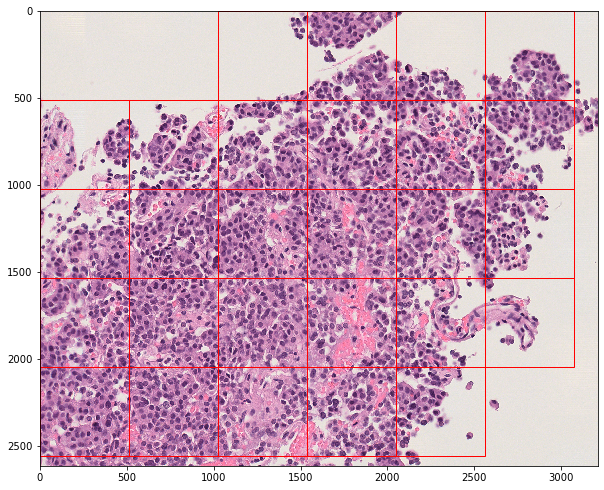

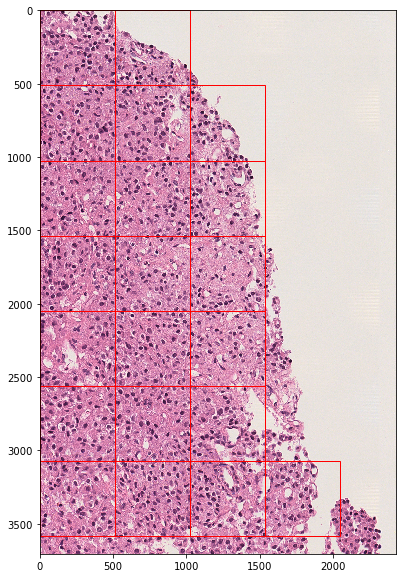

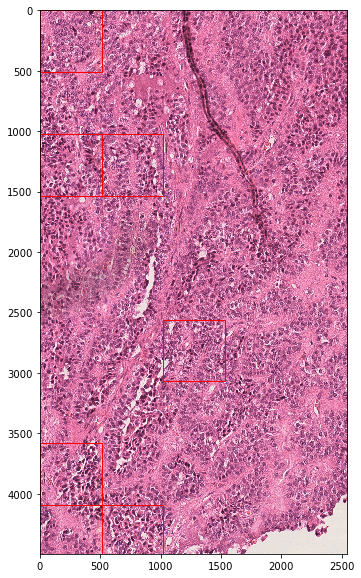

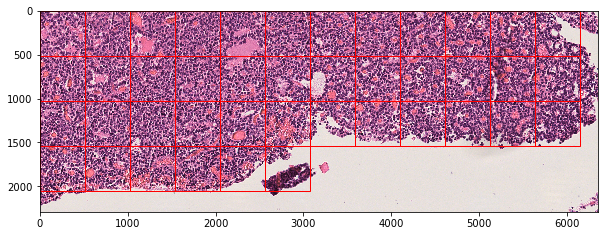

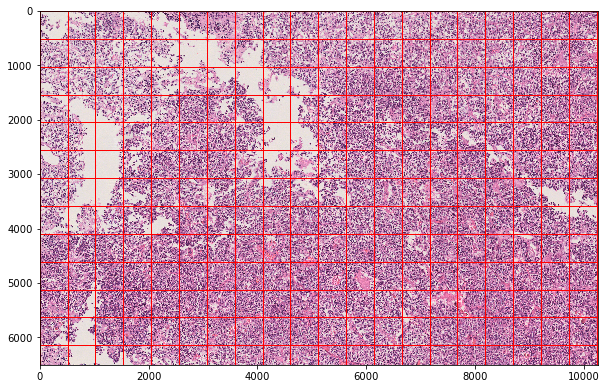

In [23]:
for ts in tilesummaries:
    ts.show_wsi_with_marked_tiles()

### ObjectManager

In [27]:
object_manager=ObjectManager(named_objects, splitter=sklearn.model_selection.train_test_split)

In [28]:
object_manager.convert_to_wsi_or_roi_object_by_tilesummaries(tilesummaries=tilesummaries)

In [29]:
object_manager.export_dataframe()

fname  labels  \
0     [Tile #170, Row #9, Column #2, Tissue 52.98%, Score 0.8672]     [9]   
1     [Tile #169, Row #9, Column #1, Tissue 51.74%, Score 0.8583]     [9]   
2    [Tile #213, Row #11, Column #3, Tissue 58.21%, Score 0.8580]     [9]   
3       [Tile #3, Row #1, Column #3, Tissue 37.23%, Score 0.8537]     [9]   
4      [Tile #67, Row #4, Column #4, Tissue 25.40%, Score 0.8502]     [9]   
..                                                            ...     ...   
349    [Tile #42, Row #9, Column #2, Tissue 54.75%, Score 0.3181]  [8, 9]   
350     [Tile #1, Row #1, Column #1, Tissue 53.66%, Score 0.3096]  [8, 9]   
351    [Tile #28, Row #6, Column #3, Tissue 54.79%, Score 0.3092]  [8, 9]   
352    [Tile #36, Row #8, Column #1, Tissue 54.11%, Score 0.3091]  [8, 9]   
353    [Tile #11, Row #3, Column #1, Tissue 59.70%, Score 0.3023]  [8, 9]   

    is_valid                                          patient_id  case_id  \
0       None  <function get_case_id_from_path at 0x7fa8e4e5eb90>   931-13   
1       None  <function get_case_id_from_path at 0x7fa8e4e5eb90>   931-13   
2       None  <function get_case_id_from_path at 0x7fa8e4e5eb90>   931-13   
3       None  <function get_case_id_from_path at 0x7fa8e4e5eb90>   931-13   
4       None  <function get_case_id_from_path at 0x7fa8e4e5eb90>   931-13   
..       ...                                                 ...      ...   
349     None  <function get_case_id_from_path at 0x7fa8e4e5eb90>  1048-12   
350     None  <function get_case_id_from_path at 0x7fa8e4e5eb90>  1048-12   
351     None  <function get_case_id_from_path at 0x7fa8e4e5eb90>  1048-12   
352     None  <function get_case_id_from_path at 0x7fa8e4e5eb90>  1048-12   
353     None  <function get_case_id_from_path at 0x7fa8e4e5eb90>  1048-12   

           slide_id dataset_type  \
0       931-13-Z-HE         None   
1       931-13-Z-HE         None   
2       931-13-Z-HE         None   
3       931-13-Z-HE         None   
4       931-13-Z-HE         None   
..              ...          ...   
349  1048-12-III-HE         None   
350  1048-12-III-HE         None   
351  1048-12-III-HE         None   
352  1048-12-III-HE         None   
353  1048-12-III-HE         None   

                                                                                                       path  
0          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
1          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
2          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
3          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
4          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
..                                                                                                      ...  
349  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
350  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
351  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
352  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
353  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  

[354 rows x 8 columns]

In [30]:
valid_pct = 0.2

In [31]:
object_manager.split(test_size=valid_pct, train_size=None, random_state=seed, shuffle=True, stratify=None)

In [32]:
object_manager.export_dataframe()

fname  labels  \
0     [Tile #170, Row #9, Column #2, Tissue 52.98%, Score 0.8672]     [9]   
1     [Tile #169, Row #9, Column #1, Tissue 51.74%, Score 0.8583]     [9]   
2    [Tile #213, Row #11, Column #3, Tissue 58.21%, Score 0.8580]     [9]   
3       [Tile #3, Row #1, Column #3, Tissue 37.23%, Score 0.8537]     [9]   
4      [Tile #67, Row #4, Column #4, Tissue 25.40%, Score 0.8502]     [9]   
..                                                            ...     ...   
349    [Tile #42, Row #9, Column #2, Tissue 54.75%, Score 0.3181]  [8, 9]   
350     [Tile #1, Row #1, Column #1, Tissue 53.66%, Score 0.3096]  [8, 9]   
351    [Tile #28, Row #6, Column #3, Tissue 54.79%, Score 0.3092]  [8, 9]   
352    [Tile #36, Row #8, Column #1, Tissue 54.11%, Score 0.3091]  [8, 9]   
353    [Tile #11, Row #3, Column #1, Tissue 59.70%, Score 0.3023]  [8, 9]   

     is_valid patient_id  case_id        slide_id       dataset_type  \
0       False       None   931-13     931-13-Z-HE  DatasetType.train   
1       False       None   931-13     931-13-Z-HE  DatasetType.train   
2       False       None   931-13     931-13-Z-HE  DatasetType.train   
3       False       None   931-13     931-13-Z-HE  DatasetType.train   
4       False       None   931-13     931-13-Z-HE  DatasetType.train   
..        ...        ...      ...             ...                ...   
349     False       None  1048-12  1048-12-III-HE  DatasetType.train   
350     False       None  1048-12  1048-12-III-HE  DatasetType.train   
351     False       None  1048-12  1048-12-III-HE  DatasetType.train   
352     False       None  1048-12  1048-12-III-HE  DatasetType.train   
353     False       None  1048-12  1048-12-III-HE  DatasetType.train   

                                                                                                       path  
0          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
1          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
2          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
3          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
4          /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
..                                                                                                      ...  
349  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
350  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
351  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
352  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  
353  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png  

[354 rows x 8 columns]

### data block api

In [65]:
final_size = 512
bs = 8

In [ ]:
batch_tfms=[fastai2.data.transforms.Normalize.from_stats(*fastai2.vision.all.imagenet_stats)]
.append(fastai2.vision.augment.aug_transforms(size=final_size,flip_vert=True))

In [67]:
data = fastai2.data.block.DataBlock(
        blocks=(TileImageBlock, fastai2.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.classification_labels,
        splitter=fastai2.data.transforms.FuncSplitter(lambda x: x.is_valid),
        item_tfms = fastai2.vision.augment.Resize(tile_size),
        batch_tfms=)

In [68]:
dls = data.dataloaders(object_manager.get_all_top_tiles(), 
                       bs=bs)

In [69]:
dls.tfms

(#2) [Pipeline: <lambda> -> TileImage.create,Pipeline: <lambda> -> MultiCategorize -> OneHotEncode]

In [56]:
dls.show_batch()

<class 'type'>
<class 'type'>
<class 'type'>
<class 'type'>
<class 'type'>
<class 'type'>
<class 'type'>
<class 'type'>


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 512 and 360 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:612

In [47]:
dls.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [59]:
b = dls.one_batch()

<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>
<class 'wsi_processing_pipeline.preprocessing.tile_image_block.TileImage'>


## Preextracted tiles

### tile paths

In [3]:
tile_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                            get_files=True, 
                                            suffix='.png', 
                                            recursive=True, 
                                            folder_name=['tiles_corticotrop_1_scoring_function_1_thresh_0.55', 
                                                         'tiles_corticotrop_2_scoring_function_1_thresh_0.55', 
                                                         'tiles_corticotrop_3_scoring_function_1_thresh_0.4', 
                                                         'tiles_gonadotrop_1_scoring_function_1_thresh_0.55', 
                                                         'tiles_gonadotrop_2_scoring_function_1_thresh_0.55', 
                                                         'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'])

49it [00:13,  3.51it/s]


In [4]:
len(tile_paths)

270410

### id and label funcs

In [5]:
def get_case_id_from_path(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def get_slide_name_from_path(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    split = path.stem.split('-')
    try:
        return f'{split[0]}-{split[1]}-{split[2]}-{split[3]}'
    except IndexError:
        return f'{split[0]}-{split[1]}-{split[2]}'
    
df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return [lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['FSH']]
    elif 'ACTH' in s:
        result = [lbs2num['corticotrop']]
        id = get_case_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(lbs2num['silent']) in str(l.values[0]):
                result.append(3)
        except:
            print(l.values)
            print(s)
            print(get_slide_name_from_path(path))
            raise
        return result
    
#def label_func_path_list(paths:List[pathlib.Path]):
#    return [label_func(p) for p in paths]

In [6]:
random_path = random.choice(tile_paths)
print(random_path)
print(f'case_id: {get_case_id_from_path(random_path)}')
print(f'slide_id: {get_slide_name_from_path(random_path)}')
print(f'labels: {label_func(random_path)}')

/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/1845-15-III-HE-ROI_31-FSH-tile-r3-c1-x0-y2048-w1024-h1024.png
case_id: 1845-15
slide_id: 1845-15-III-HE
labels: [9]


### named objects

In [7]:
named_objects=wsi_processing_pipeline.preprocessing.objects.create_named_objects_from_paths(paths=tile_paths.items,
                                                   patient_id_getter=get_case_id_from_path, # one case per patient
                                                   case_id_getter=get_case_id_from_path, 
                                                   slide_id_getter=get_slide_name_from_path,
                                                   classification_labels_getter=label_func, 
                                                   in_parallel = False)

100%|██████████| 270410/270410 [00:36<00:00, 7371.54it/s] 


### ObjectManager

In [8]:
object_manager=ObjectManager(named_objects)

In [9]:
object_manager.export_dataframe()

fname  \
0         /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/1722-12-Z-HE-ROI_4-ACTH-tile-r4-c6-x5120-y3073-w1024-h1024.png   
1         /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/1336-13-III-HE-ROI_45-ACTH-tile-r1-c5-x4096-y0-w1024-h1024.png   
2       /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/253-14-II-HE-ROI_8-ACTH-tile-r3-c11-x10242-y2049-w1024-h1024.png   
3       /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/1427-14-III-HE-ROI_4-ACTH-tile-r2-c3-x2048-y1024-w1024-h1024.png   
4        /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/498-15-II-HE-ROI_78-ACTH-tile-r7-c2-x1024-y6144-w1024-h1024.png   
...                                                                                                                                                                           ...   
270405  /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/632-13-III-HE-ROI_30-ACTH-tile-r3-c6-x5120-y2048-w1024-h1024.png   
270406     /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/813-12-III-HE-ROI_79-ACTH-tile-r2-c1-x0-y1024-w1024-h1024.png   
270407  /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/632-13-III-HE-ROI_29-ACTH-tile-r4-c4-x3072-y3072-w1024-h1024.png   
270408     /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/632-13-III-HE-ROI_56-ACTH-tile-r1-c2-x1024-y0-w1024-h1024.png   
270409  /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/827-18-III-HE-ROI_37-ACTH-tile-r3-c4-x3072-y2048-w1024-h1024.png   

        labels is_valid patient_id  case_id        slide_id dataset_type  
0       [0, 3]     None    1722-12  1722-12    1722-12-Z-HE         None  
1       [0, 3]     None    1336-13  1336-13  1336-13-III-HE         None  
2          [0]     None     253-14   253-14    253-14-II-HE         None  
3          [0]     None    1427-14  1427-14  1427-14-III-HE         None  
4          [0]     None     498-15   498-15    498-15-II-HE         None  
...        ...      ...        ...      ...             ...          ...  
270405  [0, 3]     None     632-13   632-13   632-13-III-HE         None  
270406  [0, 3]     None     813-12   813-12   813-12-III-HE         None  
270407  [0, 3]     None     632-13   632-13   632-13-III-HE         None  
270408  [0, 3]     None     632-13   632-13   632-13-III-HE         None  
270409     [0]     None     827-18   827-18   827-18-III-HE         None  

[270410 rows x 7 columns]

In [10]:
n_splits=5
current_iteration=0

In [11]:
object_manager.split_KFold_cross_validation(n_splits=n_splits, 
                                            current_iteration=current_iteration, 
                                            random_state=seed, 
                                            shuffle=True)

In [12]:
object_manager.export_dataframe()

fname  \
0         /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/1722-12-Z-HE-ROI_4-ACTH-tile-r4-c6-x5120-y3073-w1024-h1024.png   
1         /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/1336-13-III-HE-ROI_45-ACTH-tile-r1-c5-x4096-y0-w1024-h1024.png   
2       /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/253-14-II-HE-ROI_8-ACTH-tile-r3-c11-x10242-y2049-w1024-h1024.png   
3       /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/1427-14-III-HE-ROI_4-ACTH-tile-r2-c3-x2048-y1024-w1024-h1024.png   
4        /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_2_scoring_function_1_thresh_0.55/498-15-II-HE-ROI_78-ACTH-tile-r7-c2-x1024-y6144-w1024-h1024.png   
...                                                                                                                                                                           ...   
270405  /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/632-13-III-HE-ROI_30-ACTH-tile-r3-c6-x5120-y2048-w1024-h1024.png   
270406     /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/813-12-III-HE-ROI_79-ACTH-tile-r2-c1-x0-y1024-w1024-h1024.png   
270407  /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/632-13-III-HE-ROI_29-ACTH-tile-r4-c4-x3072-y3072-w1024-h1024.png   
270408     /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/632-13-III-HE-ROI_56-ACTH-tile-r1-c2-x1024-y0-w1024-h1024.png   
270409  /home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/827-18-III-HE-ROI_37-ACTH-tile-r3-c4-x3072-y2048-w1024-h1024.png   

        labels  is_valid patient_id  case_id        slide_id  \
0       [0, 3]     False    1722-12  1722-12    1722-12-Z-HE   
1       [0, 3]     False    1336-13  1336-13  1336-13-III-HE   
2          [0]     False     253-14   253-14    253-14-II-HE   
3          [0]     False    1427-14  1427-14  1427-14-III-HE   
4          [0]     False     498-15   498-15    498-15-II-HE   
...        ...       ...        ...      ...             ...   
270405  [0, 3]      True     632-13   632-13   632-13-III-HE   
270406  [0, 3]     False     813-12   813-12   813-12-III-HE   
270407  [0, 3]      True     632-13   632-13   632-13-III-HE   
270408  [0, 3]      True     632-13   632-13   632-13-III-HE   
270409     [0]      True     827-18   827-18   827-18-III-HE   

                  dataset_type  
0            DatasetType.train  
1            DatasetType.train  
2            DatasetType.train  
3            DatasetType.train  
4            DatasetType.train  
...                        ...  
270405  DatasetType.validation  
270406       DatasetType.train  
270407  DatasetType.validation  
270408  DatasetType.validation  
270409  DatasetType.validation  

[270410 rows x 7 columns]

### data block api

In [13]:
final_size = 512
bs = 6

In [14]:
data = fastai2.data.block.DataBlock(
        blocks=(ImageBlock, fastai2.data.block.MultiCategoryBlock),
        get_x=lambda x: x.path, 
        get_y=lambda x: x.classification_label,
        splitter=fastai2.data.transforms.FuncSplitter(lambda x: x.is_valid),
        item_tfms = fastai2.vision.augment.Resize(final_size),
        batch_tfms=fastai2.vision.augment.aug_transforms(flip_vert=True))

In [ ]:
dls = data.dataloaders(object_manager.objects, bs=bs)

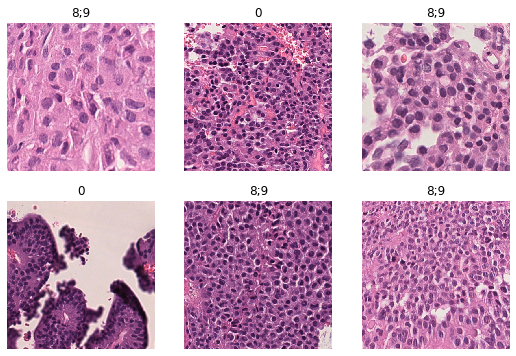

In [17]:
dls.show_batch()

# learner

## n

In [22]:
n = np.load('n_ent_f2.npy')
print(n)
#m = n+1
m=1
np.save('n_ent_f2.npy', m)
print(m)

1
1


## create

In [ ]:
epochs_frozen = 5
epochs_unfrozen = 10

In [ ]:
arch = torchvision.models.resnet.resnext101_32x8d

In [ ]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai2.metrics.accuracy_multi, fastai2.metrics.RocAucMulti],
                     pretrained=True)

In [53]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [ ]:
# In fastai1 the bias of these two layers of the custom head is set to True. In fastai2 it is set to False.
# Since I want to load model weights, that were trained with fastai1, the two layers need to be replaced, so that the weights
# can be loaded correctly
learner.model[1][4] = torch.nn.Linear(in_features=4096, out_features=512, bias=True)
learner.model[1][8] = torch.nn.Linear(in_features=512, out_features=4, bias=True)

In [49]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## name

In [24]:
nameBase = f'{n}-{arch.__name__}-size{final_size}-bs{bs}-epochs_head{epochs_frozen}'\
                f'epochs_complete{epochs_unfrozen}-seed_{seed}-n_splits_{n_splits}'\
                f'-tiles_1+2+3-cross_valid_iteration_{current_iteration}'
nameBase

'1-resnext101_32x8d-size512-bs8-epochs_head5epochs_complete10-seed_19-n_splits_5-tiles_1+2+3-cross_valid_iteration_0'

## train

In [ ]:
lr_min, lr_steep=learner.lr_find(start_lr=1e-10, end_lr=10, num_it=10)

In [28]:
## will skip this for now, since there are already trained models from the fastai 1 version of this pipeline

## load model weights

In [ ]:
model_path = PATH/'models/13-resnext/13-resnext_cross-valid-iteration-0/models/bestmodel_lr2=1e-7--lr3=1e-6_2nd_run_9'

In [ ]:
learner.load(model_path)

# prediction

In [ ]:
learner.get_preds()

# evaluation